In [2]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [3]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return numpy.array(dataX), numpy.array(dataY)

In [4]:
# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
series = pd.read_csv(r'C:\Users\SMART\Desktop\internship\AirPollutionSeoul\original Data\Measurement_info.csv',engine='python')

In [5]:
#Filtering

df=pd.DataFrame(series)
df=df[(df['Station code'] == 101) & (df['Item code'] == 9)]
#df=df[(df['Station code'] == 102) & (df['Item code'] == 9)]
#df=df[(df['Station code'] == 103) & (df['Item code'] == 9)]
#df=df[(df['Station code'] == 104) & (df['Item code'] == 9)]
df=df.drop(['Station code','Item code','Instrument status'],axis=1)
dataset = df['Average value'].values
dataset = dataset.astype('float32')

In [6]:
# normalize the dataset

minimum=min(dataset)
maximum=max(dataset)
diff=maximum-minimum
for i in range(0,len(dataset)):
    dataset[i]=(dataset[i]-minimum)/diff   

In [7]:
# split into train and test sets

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

In [8]:
# reshape into X=t and Y=t+1

look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [9]:
# reshape input to be [samples, time steps, features]

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [10]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 29s - loss: 0.0012
Epoch 2/50
 - 21s - loss: 9.0289e-04
Epoch 3/50
 - 24s - loss: 8.7175e-04
Epoch 4/50
 - 30s - loss: 8.4904e-04
Epoch 5/50
 - 25s - loss: 8.2254e-04
Epoch 6/50
 - 22s - loss: 8.0164e-04
Epoch 7/50
 - 22s - loss: 7.9071e-04
Epoch 8/50
 - 22s - loss: 7.7368e-04
Epoch 9/50
 - 23s - loss: 7.6279e-04
Epoch 10/50
 - 23s - loss: 7.5141e-04
Epoch 11/50
 - 20s - loss: 7.4726e-04
Epoch 12/50
 - 23s - loss: 7.4750e-04
Epoch 13/50
 - 29s - loss: 7.3873e-04
Epoch 14/50
 - 21s - loss: 7.3425e-04
Epoch 15/50
 - 21s - loss: 7.3427e-04
Epoch 16/50
 - 20s - loss: 7.2801e-04
Epoch 17/50
 - 20s - loss: 7.3427e-04
Epoch 18/50
 - 20s - loss: 7.2131e-04
Epoch 19/50
 - 21s - loss: 7.2925e-04
Epoch 20/50
 - 20s - loss: 7.2597e-04
Epoch 21/50
 - 22s - loss: 7.1980e-04
Epoch 22/50
 - 22s - loss: 7.1998e-04
Epoch 23/50
 - 22s - loss: 7.2472e-04
Epoch 24/50
 - 25s 

In [11]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [12]:
# calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.01 RMSE


In [13]:
# calculate mean absolute error

trainScore = mean_absolute_error(trainY, trainPredict)
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(testY, testPredict)
print('Test Score: %.2f MAE' % (testScore))

Train Score: 0.01 MAE
Test Score: 0.01 MAE


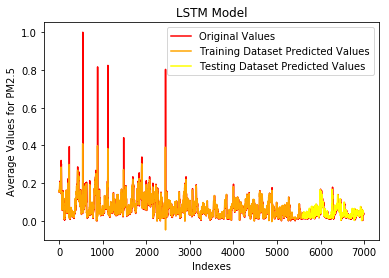

In [20]:
# Make a new dataframe of your prediction values
df_new = pd.DataFrame(trainPredict)
df_new.columns = ['trainPredict']

# Retrieve index values
new_index = df_new['trainPredict'].tail(len(testPredict)).index
new_index+=len(testPredict)

# Make a dataframe with your prediction values and your index
new_series = pd.DataFrame(index=new_index,data = testPredict)

# Merge the dataframes
df_new = pd.merge(df_new, new_series, how = 'outer', left_index=True, right_index=True)
df_new.columns = ['trainPredict', 'testPredict']

# plot graphs
plt.title("LSTM Model")
plt.xlabel("Indexes")
plt.ylabel("Average Values for PM2.5")
plt.plot(dataset,color='red',label='Original Values')
plt.plot(df_new['trainPredict'],color='orange',label='Training Dataset Predicted Values')
plt.plot(df_new['testPredict'],color='yellow',label='Testing Dataset Predicted Values')
plt.legend()
plt.show()